In [95]:
import numpy as np
#%matplotlib qt
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader
import math
import torch.nn.functional as F


def enforce_zero_terminal_snr(betas):
    # Convert betas to alphas_bar_sqrt
    alphas = 1 - betas
    alphas_bar = alphas.cumprod(0)
    alphas_bar_sqrt = alphas_bar.sqrt()

    # Store old values.
    alphas_bar_sqrt_0 = alphas_bar_sqrt[0].clone()
    alphas_bar_sqrt_T = alphas_bar_sqrt[-1].clone()
    # Shift so last timestep is zero.
    alphas_bar_sqrt -= alphas_bar_sqrt_T
    # Scale so first timestep is back to old value.
    alphas_bar_sqrt *= alphas_bar_sqrt_0 / (
            alphas_bar_sqrt_0 - alphas_bar_sqrt_T)

    # Convert alphas_bar_sqrt to betas
    alphas_bar = alphas_bar_sqrt ** 2
    alphas = alphas_bar[1:] / alphas_bar[:-1]
    alphas = torch.cat([alphas_bar[0:1], alphas])
    betas = 1 - alphas
    return betas


class Diffusion:
    def __init__(self, noise_steps=1000, img_size=64, device="cuda"):
        self.noise_steps = noise_steps
        self.img_size = img_size
        self.device = device
        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return enforce_zero_terminal_snr(
            torch.tensor([(math.sqrt(0.00085) * (1 - (i - 1) / (self.noise_steps - 1)) + math.sqrt(0.012) * (i - 1) / (
                    self.noise_steps - 1)) ** 2 for i in range(self.noise_steps)]).to(self.device))

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x, device=self.device)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, sqrt_alpha_hat * Ɛ - sqrt_one_minus_alpha_hat * x

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,), device=self.device)

    def sample(self, model, n):
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                v_prediction = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                alpha_hat_prev = self.alpha_hat[t - 1][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                x_zero = torch.sqrt(alpha_hat) * x - torch.sqrt(1 - alpha_hat) * v_prediction
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = torch.sqrt(alpha_hat_prev) * beta / (1 - alpha_hat) * x_zero + torch.sqrt(alpha) * (
                        1 - alpha_hat_prev) / (1 - alpha_hat) * x + torch.sqrt(
                    beta) * noise
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x

In [96]:
from torch.utils.data import Dataset
from PIL import Image
from os.path import isfile
from glob import glob


def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result


class CustomImageDataset(Dataset):
    def __init__(self, root: str, transforms: list | None = None):
        self.img_dir = root
        self.transform = transforms
        self.files = []

        for path in glob(self.img_dir + '/**', recursive=True):
            if isfile(path):
                im = Image.open(path)
                if im.size[0] > 200 and im.size[1] > 200:
                    im = expand2square(im, (255, 255, 255))
                    if self.transform:
                        for transform in self.transform:
                            self.files.append(transform(im))
                    else:
                        self.files.append(im)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        return self.files[idx]

In [97]:
def data_getter(dataset_path: str, size: int = 64):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Pad(padding=20, padding_mode='constant', fill=(255, 255, 255)),
        torchvision.transforms.Resize(size=(size, size)),
        torchvision.transforms.RandomAdjustSharpness(2, p=1),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambda t: (t * 2) - 1)
    ])

    transform_rotR = torchvision.transforms.Compose([
        torchvision.transforms.Pad(padding=20, padding_mode='constant', fill=(255, 255, 255)),
        torchvision.transforms.RandomAdjustSharpness(2, p=1),
        torchvision.transforms.RandomRotation(degrees=(30, 60), fill=(255, 255, 255)),
        torchvision.transforms.Resize(size=(size, size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambda t: (t * 2) - 1)
    ])

    transform_rotL = torchvision.transforms.Compose([
        torchvision.transforms.Pad(padding=20, padding_mode='constant', fill=(255, 255, 255)),
        torchvision.transforms.RandomAdjustSharpness(2, p=1),
        torchvision.transforms.RandomRotation(degrees=(-60, -30), fill=(255, 255, 255)),
        torchvision.transforms.Resize(size=(size, size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambda t: (t * 2) - 1)
    ])

    transform_Persp = torchvision.transforms.Compose([
        torchvision.transforms.Pad(padding=20, padding_mode='constant', fill=(255, 255, 255)),
        torchvision.transforms.RandomAdjustSharpness(2, p=1),
        torchvision.transforms.RandomPerspective(p=1, fill=(255, 255, 255)),
        torchvision.transforms.Resize(size=(size, size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambda t: (t * 2) - 1)
    ])

    transform_affine = torchvision.transforms.Compose([
        torchvision.transforms.Pad(padding=20, padding_mode='constant', fill=(255, 255, 255)),
        torchvision.transforms.RandomAdjustSharpness(2, p=1),
        torchvision.transforms.RandomAffine(degrees=(-45, 45), fill=(255, 255, 255)),
        torchvision.transforms.Resize(size=(size, size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambda t: (t * 2) - 1)
    ])

    transform_HorizontalFlip = torchvision.transforms.Compose([
        torchvision.transforms.Pad(padding=20, padding_mode='constant', fill=(255, 255, 255)),
        torchvision.transforms.RandomAdjustSharpness(2, p=1),
        torchvision.transforms.RandomHorizontalFlip(p=1),
        torchvision.transforms.Resize(size=(size, size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambda t: (t * 2) - 1)
    ])

    dataset = CustomImageDataset(root=dataset_path,
                                 transforms=[transform, transform_rotR, transform_rotL, transform_Persp,
                                             transform_affine, transform_HorizontalFlip])
    return dataset

In [98]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(...,) + (None,) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """

    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i + 1], \
                                          time_emb_dim) \
                                    for i in range(len(down_channels) - 1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i + 1], \
                                        time_emb_dim, up=True) \
                                  for i in range(len(up_channels) - 1)])

        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

    def save(self):
        torch.save(self.state_dict(), 'model_last.pth')

In [99]:
def train(model: nn.Module, device: str = 'cuda', epoch_count: int = 50, img_size: int = 64):
    mse = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
    diffusion = Diffusion(img_size=img_size)
    set = data_getter('./dataset', size=img_size)
    for epoch in tqdm(range(epoch_count)):
        for image in tqdm(DataLoader(set, batch_size=64, shuffle=True), position=0):
            image = image.to(device)
            time_moment_for_img = diffusion.sample_timesteps(image.shape[0])
            noised_img, v_init = diffusion.noise_images(image, time_moment_for_img)
            noised_img = noised_img.to(device)
            v_pred = model(noised_img, time_moment_for_img)
            loss = mse(v_pred, v_init)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print(f'{loss}')
            #torch.save(model.state_dict(), '/kaggle/working/model.pth')
            new_img = diffusion.sample(model, 2)
            for i in range(2):
                plt.imshow(torchvision.transforms.ToPILImage()(new_img[i, ...]))
                plt.show()

In [92]:
model = SimpleUnet().to('cuda')
#model = UNet().to('cuda')

100%|██████████| 235/235 [00:51<00:00,  4.59it/s]


0.16783443093299866


999it [00:05, 196.19it/s]


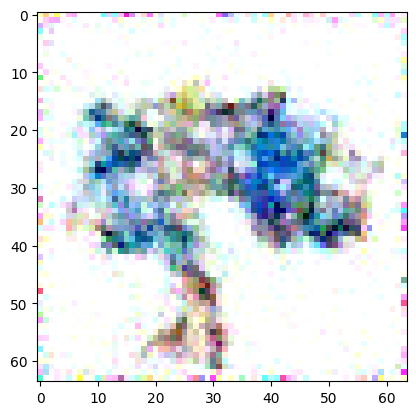

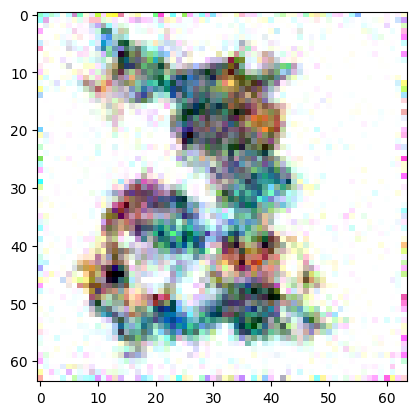

  8%|▊         | 4/50 [03:43<42:46, 55.80s/it]


KeyboardInterrupt: 

In [82]:
#model.load_state_dict(torch.load('./model_last.pth'))
train(model=model)

In [12]:
diffusion = Diffusion(img_size=128)
n_img = 25

In [13]:

fig = plt.figure(figsize=(128, 128))
rows, cols = 5, 5
new_img = diffusion.sample(model, n_img)
for i in range(1, n_img + 1):
    img = torchvision.transforms.ToPILImage()(new_img[i - 1, ...])
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
plt.show()

999it [02:08,  7.78it/s]


In [16]:
torch.save(model.state_dict(), 'model_last.pth')

In [100]:
set = data_getter('./dataset', size=64)
k = 0
len(set)


13710

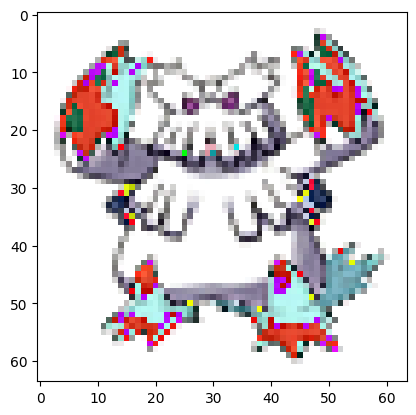

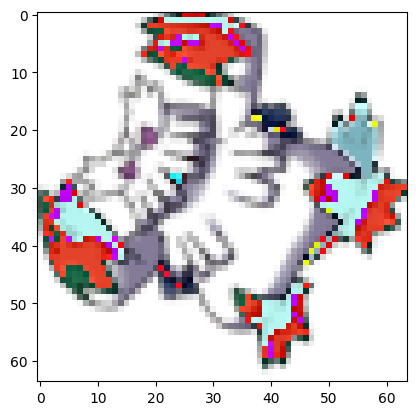

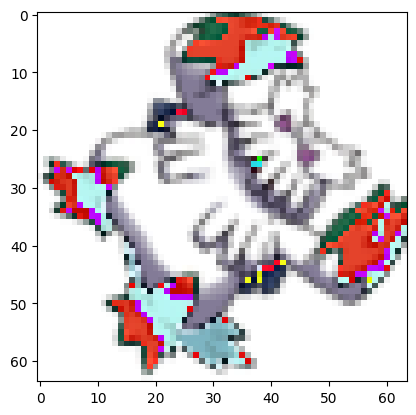

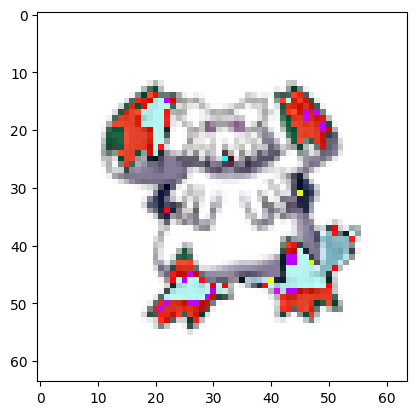

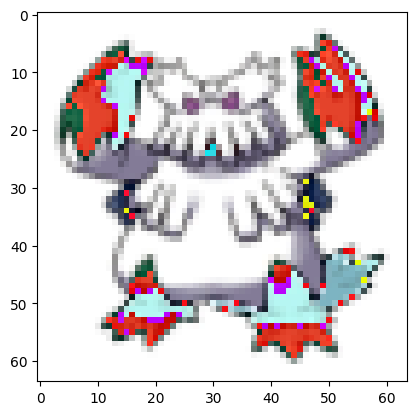

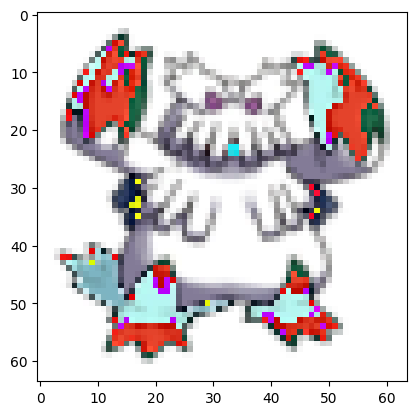

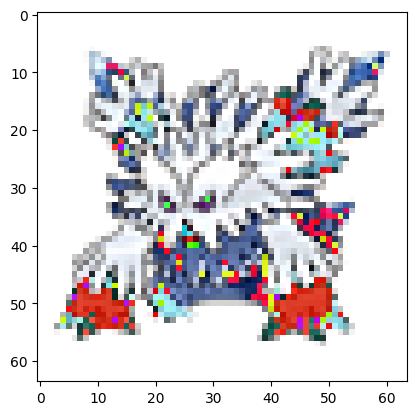

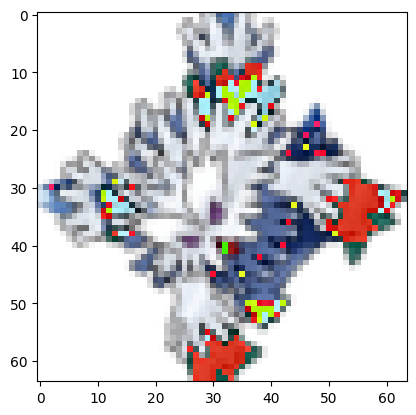

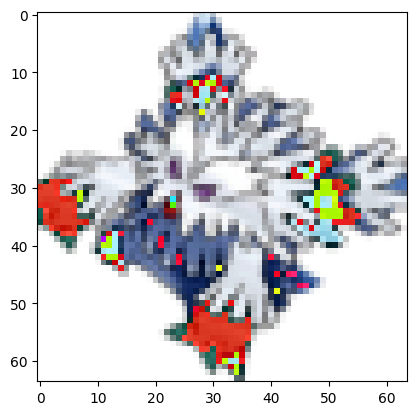

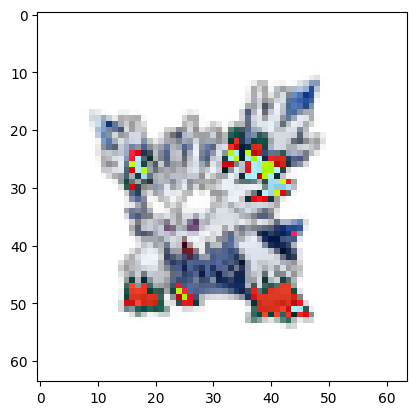

In [101]:
for i in range(10):
    plt.imshow(torchvision.transforms.ToPILImage()(set[i]))
    plt.show()